In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import beta as scipy_beta

# Set random seed for reproducibility
np.random.seed(42)


In [2]:

# Create realistic exoplanet detection data based on actual survey statistics
detection_methods = ["Transit", "Radial Velocity", "Direct Imaging", "Microlensing"]

# Realistic detection rates based on actual exoplanet surveys
detection_data = {
    "method": detection_methods,
    "attempts": [1000, 800, 200, 150],  # Number of observation attempts
    "successes": [450, 320, 25, 18],  # Successful detections
    "description": [
        "Kepler/TESS-like transit surveys",
        "Ground-based RV surveys",
        "Direct imaging surveys",
        "Gravitational microlensing",
    ],
}

df = pd.DataFrame(detection_data)
print("\nExoplanet Detection Data:")
print(df[["method", "attempts", "successes"]])



Exoplanet Detection Data:
            method  attempts  successes
0          Transit      1000        450
1  Radial Velocity       800        320
2   Direct Imaging       200         25
3     Microlensing       150         18


In [3]:
# Calculate observed success rates
df["success_rate"] = df["successes"] / df["attempts"]
print(f"\nObserved Success Rates:")
for i, row in df.iterrows():
    print(f"{row['method']}: {row['success_rate']:.3f}")



Observed Success Rates:
Transit: 0.450
Radial Velocity: 0.400
Direct Imaging: 0.125
Microlensing: 0.120


In [4]:
# Beta-Binomial Conjugate Model
print("\n" + "=" * 50)
print("BETA-BINOMIAL CONJUGATE MODEL")
print("=" * 50)



BETA-BINOMIAL CONJUGATE MODEL


In [5]:
# Focus on Transit method for detailed conjugate analysis
method_idx = 0
n_trials = df.loc[method_idx, "attempts"]
n_success = df.loc[method_idx, "successes"]

print(f"\nAnalyzing {df.loc[method_idx, 'method']} method:")
print(f"Observation attempts: {n_trials}")
print(f"Successful detections: {n_success}")
print(f"Observed success rate: {n_success/n_trials:.3f}")



Analyzing Transit method:
Observation attempts: 1000
Successful detections: 450
Observed success rate: 0.450


In [6]:
# Conjugate analysis (analytical solution)
alpha_prior = 2  # Slightly informative prior
beta_prior = 3  # Expecting moderate success rates

# Posterior: Beta(α₀ + successes, β₀ + failures)
alpha_posterior = alpha_prior + n_success
beta_posterior = beta_prior + (n_trials - n_success)

print(f"\nConjugate Analysis:")
print(f"Prior: Beta({alpha_prior}, {beta_prior})")
print(f"Posterior: Beta({alpha_posterior}, {beta_posterior})")



Conjugate Analysis:
Prior: Beta(2, 3)
Posterior: Beta(452, 553)


In [7]:
# Calculate analytical posterior statistics
analytical_mean = alpha_posterior / (alpha_posterior + beta_posterior)
analytical_var = (alpha_posterior * beta_posterior) / (
    (alpha_posterior + beta_posterior) ** 2 * (alpha_posterior + beta_posterior + 1)
)

print(f"Analytical posterior mean: {analytical_mean:.4f}")
print(f"Analytical posterior std: {np.sqrt(analytical_var):.4f}")


Analytical posterior mean: 0.4498
Analytical posterior std: 0.0157


In [8]:
# PyMC Model for single method
with pm.Model() as beta_binomial_model:
    # Prior for detection probability
    p = pm.Beta("detection_probability", alpha=alpha_prior, beta=beta_prior)

    # Likelihood - binomial distribution for count data
    obs = pm.Binomial("observed_detections", n=n_trials, p=p, observed=n_success)

    # Sample from posterior
    trace = pm.sample(2000, tune=1000, chains=2, random_seed=42, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [detection_probability]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.


In [9]:
# Compare analytical vs MCMC results
mcmc_mean = trace.posterior["detection_probability"].mean().values
mcmc_std = trace.posterior["detection_probability"].std().values

print(f"\nResults Comparison:")
print(f"Analytical posterior mean: {analytical_mean:.4f}")
print(f"MCMC posterior mean: {mcmc_mean:.4f}")
print(f"Difference in means: {abs(analytical_mean - mcmc_mean):.6f}")
print(f"Analytical posterior std: {np.sqrt(analytical_var):.4f}")
print(f"MCMC posterior std: {mcmc_std:.4f}")



Results Comparison:
Analytical posterior mean: 0.4498
MCMC posterior mean: 0.4504
Difference in means: 0.000675
Analytical posterior std: 0.0157
MCMC posterior std: 0.0155


In [10]:
# Hierarchical Beta-Binomial Model
print("\n" + "=" * 50)
print("HIERARCHICAL BETA-BINOMIAL MODEL")
print("=" * 50)

with pm.Model() as hierarchical_model:
    # Hyperpriors for population-level parameters
    mu = pm.Beta("population_mean", alpha=1, beta=1)  # Population mean detection rate
    kappa = pm.Exponential(
        "population_concentration", lam=0.1
    )  # How similar methods are

    # Convert to alpha, beta parameterization for Beta distribution
    alpha = mu * kappa
    beta = (1 - mu) * kappa

    # Method-specific detection probabilities
    p_methods = pm.Beta(
        "method_probabilities", alpha=alpha, beta=beta, shape=len(detection_methods)
    )

    # Observations for each method
    for i, method in enumerate(detection_methods):
        pm.Binomial(
            f"detections_{method}",
            n=df.loc[i, "attempts"],
            p=p_methods[i],
            observed=df.loc[i, "successes"],
        )

    # Sample from posterior
    hierarchical_trace = pm.sample(
        2000, tune=1000, chains=2, random_seed=42, target_accept=0.9
    )


HIERARCHICAL BETA-BINOMIAL MODEL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [population_mean, population_concentration, method_probabilities]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


In [11]:
# Extract results
method_probs_samples = hierarchical_trace.posterior["method_probabilities"]
method_means = method_probs_samples.mean(dim=["chain", "draw"]).values
method_stds = method_probs_samples.std(dim=["chain", "draw"]).values

print("Hierarchical Model Results:")
for i, method in enumerate(detection_methods):
    print(f"{method}: {method_means[i]:.3f} ± {method_stds[i]:.3f}")


Hierarchical Model Results:
Transit: 0.449 ± 0.015
Radial Velocity: 0.399 ± 0.017
Direct Imaging: 0.131 ± 0.023
Microlensing: 0.128 ± 0.027


In [12]:
# Individual Plots
print("\n" + "=" * 50)
print("VISUALIZATION")
print("=" * 50)



VISUALIZATION


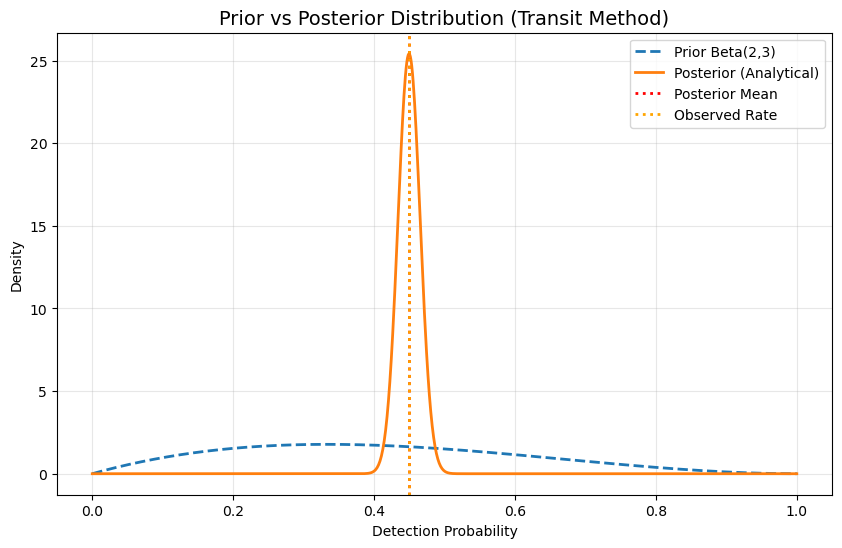

In [13]:
# Plot 1: Prior vs Posterior comparison
plt.figure(figsize=(10, 6))
x = np.linspace(0, 1, 1000)
prior_dist = scipy_beta(alpha_prior, beta_prior)
posterior_dist = scipy_beta(alpha_posterior, beta_posterior)

plt.plot(x, prior_dist.pdf(x), label="Prior Beta(2,3)", linestyle="--", linewidth=2)
plt.plot(x, posterior_dist.pdf(x), label="Posterior (Analytical)", linewidth=2)
plt.axvline(
    analytical_mean, color="red", linestyle=":", label="Posterior Mean", linewidth=2
)
plt.axvline(
    n_success / n_trials,
    color="orange",
    linestyle=":",
    label="Observed Rate",
    linewidth=2,
)
plt.title("Prior vs Posterior Distribution (Transit Method)", fontsize=14)
plt.xlabel("Detection Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

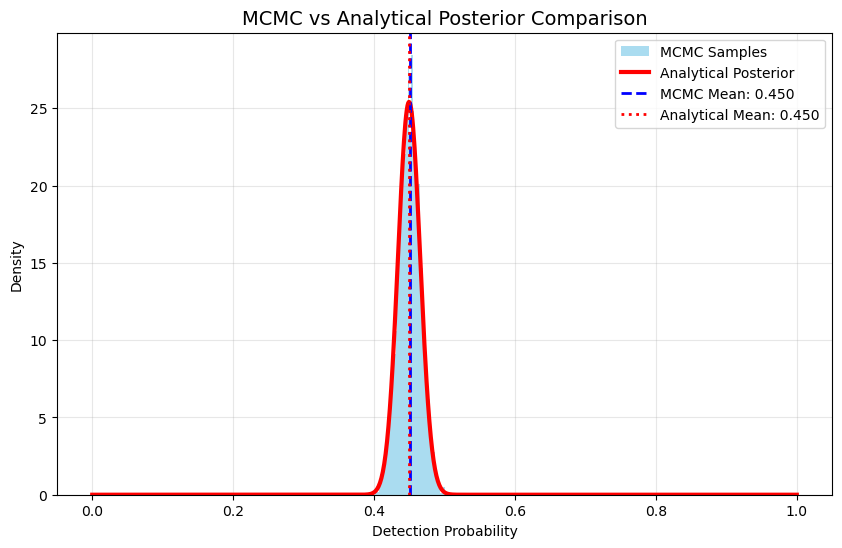

In [14]:
# Plot 2: MCMC vs Analytical comparison
plt.figure(figsize=(10, 6))
posterior_samples = trace.posterior["detection_probability"].values.flatten()
plt.hist(
    posterior_samples,
    bins=50,
    density=True,
    alpha=0.7,
    label="MCMC Samples",
    color="skyblue",
)
plt.plot(x, posterior_dist.pdf(x), "r-", linewidth=3, label="Analytical Posterior")
plt.axvline(
    mcmc_mean,
    color="blue",
    linestyle="--",
    label=f"MCMC Mean: {mcmc_mean:.3f}",
    linewidth=2,
)
plt.axvline(
    analytical_mean,
    color="red",
    linestyle=":",
    label=f"Analytical Mean: {analytical_mean:.3f}",
    linewidth=2,
)
plt.title("MCMC vs Analytical Posterior Comparison", fontsize=14)
plt.xlabel("Detection Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

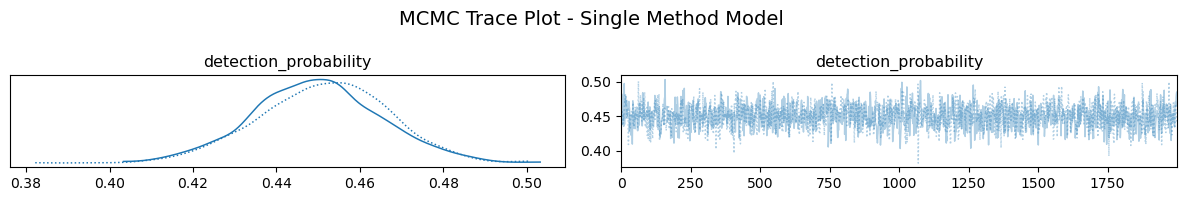

In [15]:
# Plot 3: Trace plot for single method model
az.plot_trace(trace, var_names=["detection_probability"])
plt.suptitle("MCMC Trace Plot - Single Method Model", fontsize=14)
plt.tight_layout()
plt.show()


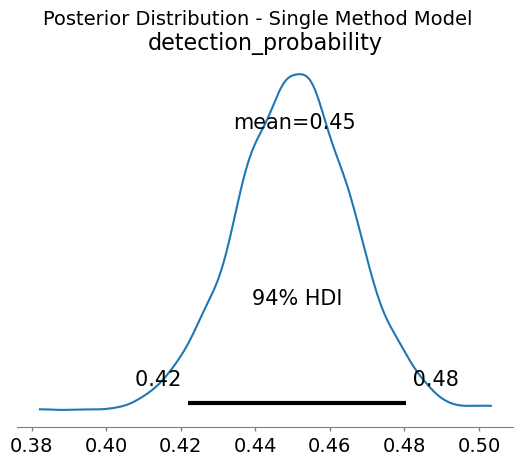

In [16]:
# Plot 4: Posterior plot for single method
az.plot_posterior(trace, var_names=["detection_probability"])
plt.suptitle("Posterior Distribution - Single Method Model", fontsize=14)
plt.show()


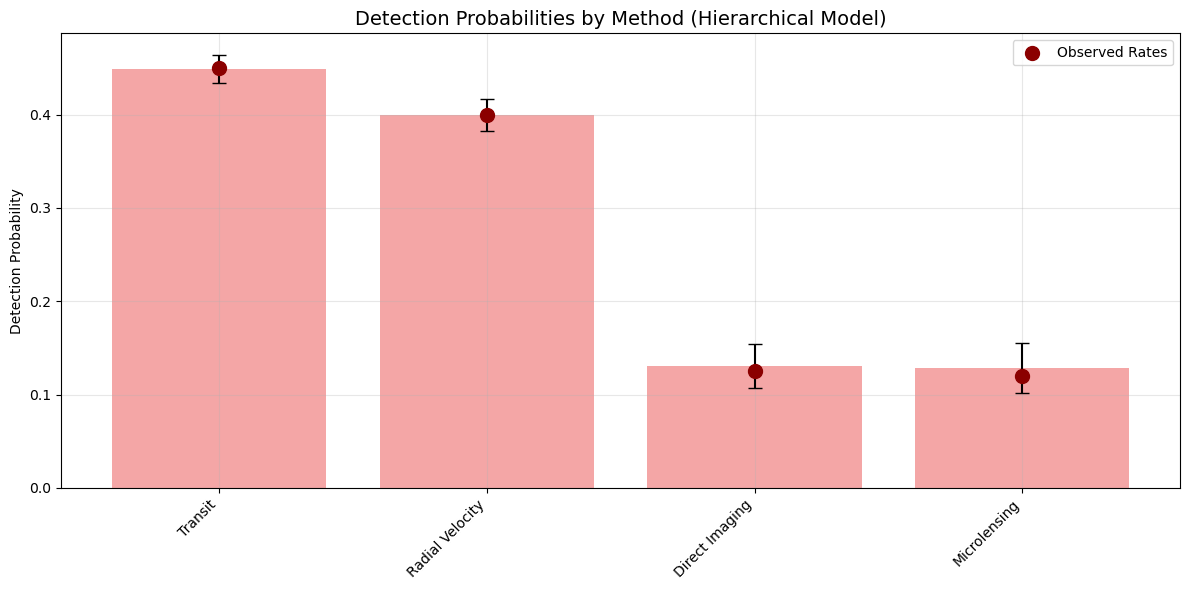

In [17]:
# Plot 5: Method comparison
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(detection_methods))
bars = plt.bar(
    x_pos, method_means, yerr=method_stds, capsize=5, alpha=0.7, color="lightcoral"
)
plt.scatter(
    x_pos, df["success_rate"], color="darkred", s=100, zorder=5, label="Observed Rates"
)
plt.xticks(x_pos, detection_methods, rotation=45, ha="right")
plt.title("Detection Probabilities by Method (Hierarchical Model)", fontsize=14)
plt.ylabel("Detection Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


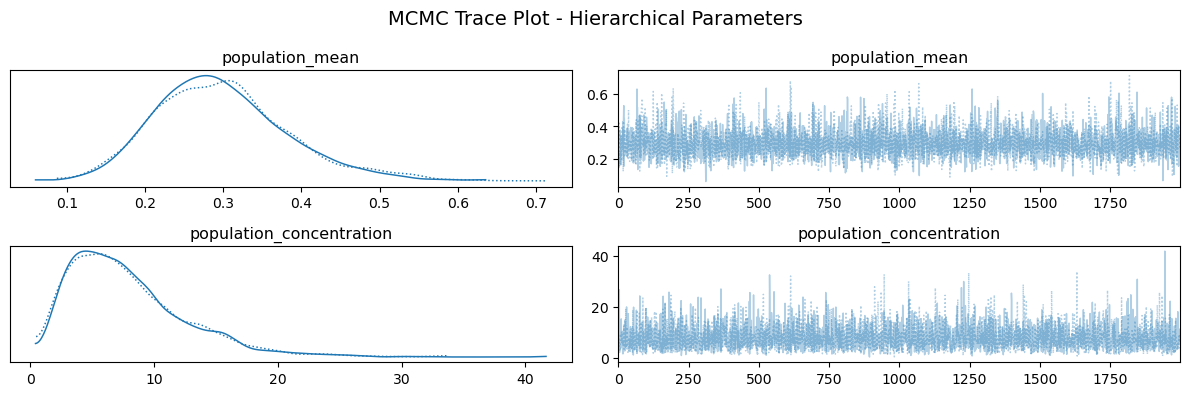

In [18]:
# Plot 6: Hierarchical model trace
az.plot_trace(
    hierarchical_trace, var_names=["population_mean", "population_concentration"]
)
plt.suptitle("MCMC Trace Plot - Hierarchical Parameters", fontsize=14)
plt.tight_layout()
plt.show()


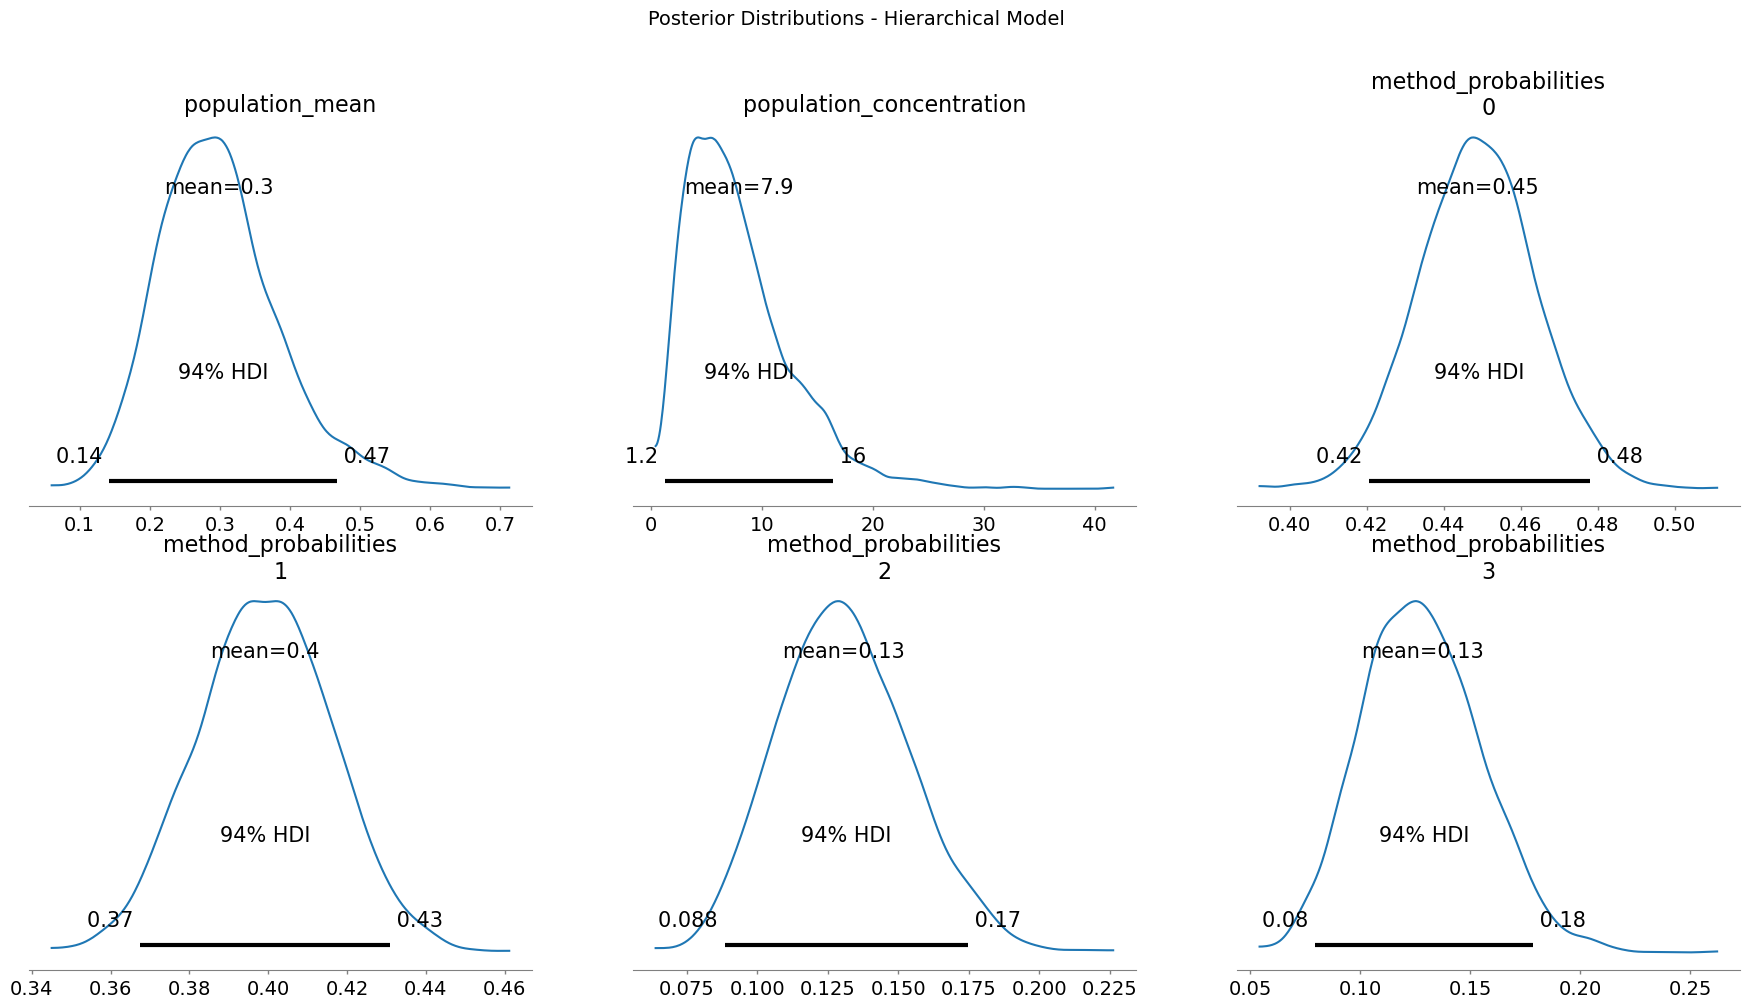

In [19]:
# Plot 7: Hierarchical model posteriors
az.plot_posterior(
    hierarchical_trace,
    var_names=["population_mean", "population_concentration", "method_probabilities"],
)
plt.suptitle("Posterior Distributions - Hierarchical Model", fontsize=14)
plt.show()

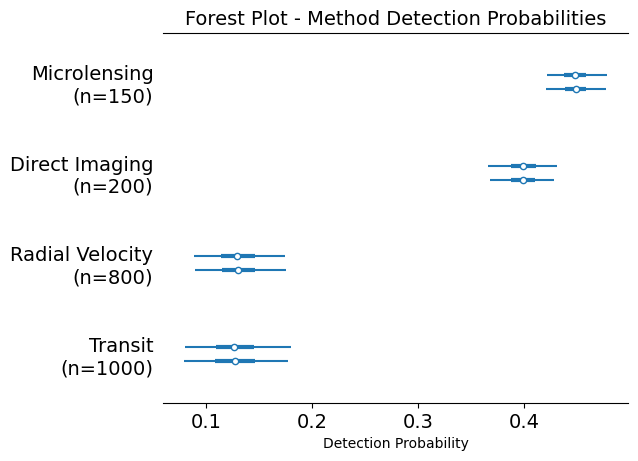

In [20]:
# Plot 8: Forest plot for method comparison
az.plot_forest(hierarchical_trace, var_names=["method_probabilities"])
plt.title("Forest Plot - Method Detection Probabilities", fontsize=14)
plt.xlabel("Detection Probability")
labels = [
    f'{method}\n(n={df.loc[i, "attempts"]})'
    for i, method in enumerate(detection_methods)
]
plt.gca().set_yticklabels(labels)
plt.show()


Sampling: [detections_Direct Imaging, detections_Microlensing, detections_Radial Velocity, detections_Transit]


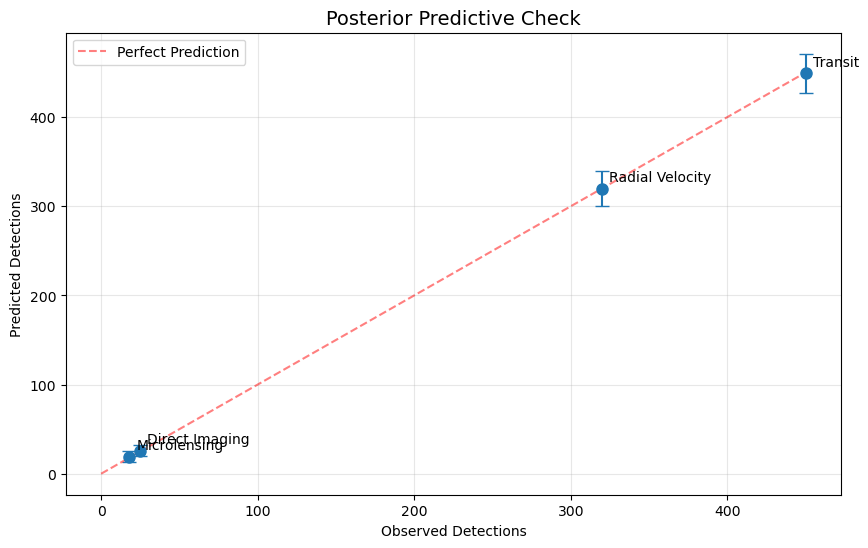

In [21]:
# Plot 9: Posterior predictive check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(hierarchical_trace, random_seed=42)

plt.figure(figsize=(10, 6))
observed = df["successes"].values
predicted_samples = np.array(
    [
        ppc.posterior_predictive[f"detections_{method}"].values.flatten()
        for method in detection_methods
    ]
)
predicted_means = predicted_samples.mean(axis=1)
predicted_stds = predicted_samples.std(axis=1)

plt.errorbar(
    observed, predicted_means, yerr=predicted_stds, fmt="o", capsize=5, markersize=8
)
max_val = max(max(observed), max(predicted_means))
plt.plot([0, max_val], [0, max_val], "r--", alpha=0.5, label="Perfect Prediction")
plt.xlabel("Observed Detections")
plt.ylabel("Predicted Detections")
plt.title("Posterior Predictive Check", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add method labels
for i, method in enumerate(detection_methods):
    plt.annotate(
        method,
        (observed[i], predicted_means[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
    )
plt.show()
